In [1]:
import cards as ccg
import pandas as pd
import numpy as np

cards = pd.read_csv('cardsTable.csv')
cardsList = [ccg.Minion(i) for i in cards.values.tolist()]

cores = pd.read_csv('cores.csv')
coreList = [ccg.Core(i) for i in cores.values.tolist()]

playersNum = 2
piles = [[ccg.Pile(cardsList, 10) for _ in range(4)] for I in range(playersNum)]
cores = np.random.choice(coreList, 2)
decks = [ccg.Deck(cores[i], piles[i], i) for i in range(playersNum)]

In [2]:
session = ccg.Session(decks)

In [3]:
from __future__ import print_function
import numpy as np
import torch
print(torch.__version__)

0.4.1


In [4]:
import copy
import random

def observationTable(table, turn):
    tables = copy.deepcopy(table)
    for i in tables:
        for j in range(len(i), 8):
            i.append(observationMinion(ccg.Minion().getCurState()))
        i[0] = observationCore(i[0])
        for j in range(1, len(i)):
            i[j] = observationMinion(i[j])
        buf = i[1:]
        #random.shuffle(buf)
        i[1:] = buf
    tables[0], tables[turn] = tables[turn], tables[0]
    for i in range(len(tables)):
        tables[i] = np.hstack(tuple(tables[i]))
    return np.hstack(tuple(tables))

def observationCore(core):
    return np.array(list(core))

def observationMinion(minion):
    state = list(minion)
    state[5] = int(state[5])
    return np.array(state)

def observationPile(pile):
    pileCopy = copy.deepcopy(pile)
    #random.shuffle(pileCopy)
    for i in range(len(pileCopy)):
        pileCopy[i] = list(pileCopy[i])
        if pileCopy[i][1] == None:
            pileCopy[i][1] = observationMinion(ccg.Minion().getCurState())
        else:
            pileCopy[i][1] = observationMinion(pileCopy[i][1])
        pileCopy[i] = [pileCopy[i][0]] + pileCopy[i][1].tolist()
    return np.hstack(tuple(pileCopy))

def createStateObservation(state):
    
    observations = dict()
    observations["main"] = observationTable(state["battleGround"]["table"], state["turn"])
    pilesObs = []
    
    for i in state["piles"]:   
        pilesObs.append(observationPile(i))
        
    pilesObs[0], pilesObs[state["turn"]] = pilesObs[state["turn"]], pilesObs[0]
    pilesObs = np.hstack(tuple(pilesObs))
    observations["main"] = observations["main"].tolist() + pilesObs.tolist()

    return observations["main"]
    
    observations["unitsOtCore"]
    observations["unitsActtack"] = []
    for i in range(len(state["table"])):
        for j in range(len()):
            pass
    
    observations["playCard"] = observations["main"]
    
    return observations


In [5]:
from a2c_v1 import ActorNetwork, ValueNetwork
import math

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [6]:
state = session.reset()
state_dim = len(createStateObservation(session.getObservation()))
n_actions = 1 + 7 * 8 + 4

value_network = ValueNetwork(state_dim)
value_network_optim = torch.optim.Adam(value_network.parameters(), lr=0.01)

actor_network = ActorNetwork(state_dim ,n_actions)
actor_network_optim = torch.optim.Adam(actor_network.parameters(), lr = 0.01)

In [7]:
import numpy

def envActionFromAction(action, home_turn):
    env_action = ("skip")
    if action == 0:
        pass
    elif(action < n_actions - 4):
        action_attack = action - 1
        env_action = ("attack", [home_turn, action_attack // 8], [1 - home_turn, action_attack % 8])
    else:
        env_action = ("play", action - (n_actions - 4))
    return env_action

def play_and_record(agent, session, n_steps = 1000, home_turn=0):
    rewards = 0
    
    states_log = []
    actions_log = []
    rewards_log = []
    final_state = None
    final_r = 0
    state = createStateObservation(session.getObservation())
    is_done = False
    
    for i in range(n_steps):
        
        table = session.getObservation()["battleGround"]["table"]
        hits_diff = table[home_turn][0][2] - table[1 - home_turn][0][2]
        
        states_log.append(state)
        #get actions
        actions = session.getValidActions()
        log_softmax_action = agent.get_qvalues([state])
        softmax_action = torch.exp(log_softmax_action)
        qvalues = softmax_action.data.cpu().numpy()
        valid_actions = [[]]
        for i in range(n_actions):
            env_action = envActionFromAction(i, home_turn)
            valid_actions[0].append(env_action in actions)
            
        #get valid action from network
        action = agent.sample_actions(qvalues, np.array(valid_actions))[0]
        one_hot_action = [int(k == action) for k in range(n_actions)]
        actions_log.append(one_hot_action)
        
        #step
        env_action = envActionFromAction(action, home_turn)
        next_s = session.action(env_action)
        
        endGame = next_s["end"]
        
        #enemy turn
        if (next_s["turn"] != home_turn) and not endGame:
            next_s = session.action(("skip"))
            endGame = next_s["end"]
        
        #calc reward
        table = next_s["battleGround"]["table"]
        reward = table[home_turn][0][2] - table[1 - home_turn][0][2] - hits_diff - 0.1
        rewards_log.append(reward)
        
        final_state = next_s
        
        #morph game state to network state
        next_s = createStateObservation(next_s)
        
        state = next_s
        
        if endGame:
            is_done = True
            session.reset()
            break

    if not is_done:
        final_r = value_network(Variable(torch.Tensor([createStateObservation(final_state)]))).cpu().data.numpy()

    return states_log, actions_log, rewards_log, final_r, final_state

In [8]:
#exp_replay = ReplayBuffer(1000)
_, _, rewards_log, _, _ = play_and_record(actor_network, session, n_steps=10, home_turn=0)
rewards_log

C:\Users\GospodinNoob\rl_ccg\a2c_v1.py:47: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(qvalues)


[-0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, -0.1, 1.9, -0.1]

### Training

In [9]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

state = session.reset()
state_dim = len(createStateObservation(session.getObservation()))
n_actions = 1 + 7 * 8 + 4

value_network = ValueNetwork(state_dim)
value_network_optim = torch.optim.Adam(value_network.parameters(), lr=0.01)

actor_network = ActorNetwork(state_dim ,n_actions)
actor_network_optim = torch.optim.Adam(actor_network.parameters(), lr = 0.01)

discount = 0.99

home_turn = 0

In [10]:
mean_rewards = []
mean_hits_diff = []
mean_enemy_core_hits = []
mean_win = []
mean_loss_actor = []
mean_loss_value = []

In [11]:
def discount_reward(r, gamma, final_r):
    discounted_r = np.zeros_like(r)
    running_add = final_r
    for t in reversed(range(0, len(r))):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

<Figure size 432x288 with 0 Axes>

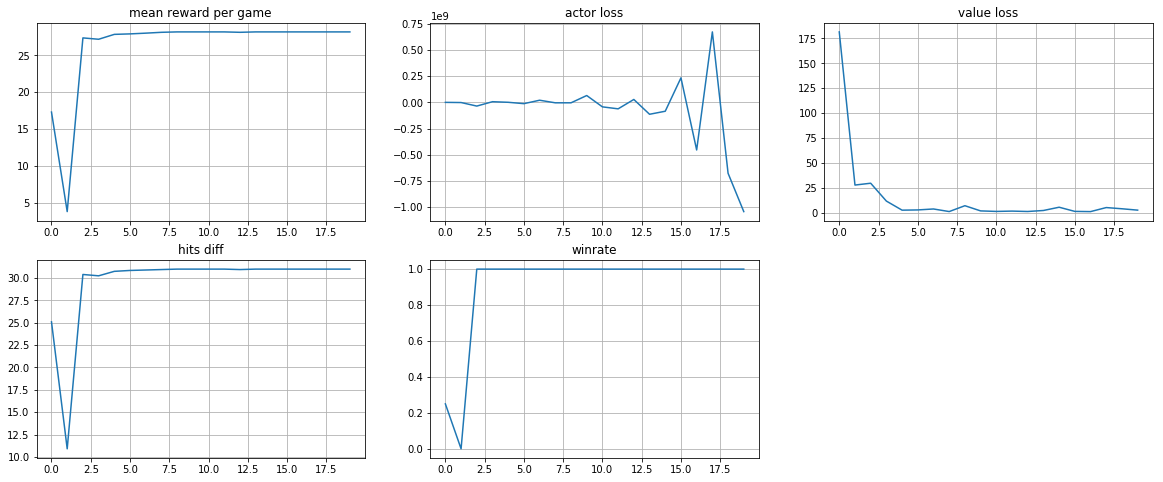

  0%|▏                                                                         | 1049/400000 [01:00<6:10:15, 17.96it/s]

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

  0%|▏                                                                         | 1049/400000 [01:20<6:10:15, 17.96it/s]

In [12]:
import pickle
np.random.seed(0)
torch.manual_seed(0)

state = session.reset()
batch_loss_actor = []
batch_loss_value = []
for i in trange(4 * 10**5):
    
    
    states, actions, rewards, final_r, _ =  play_and_record(actor_network, session, n_steps=30, home_turn=home_turn)
    
    actions_var = Variable(torch.Tensor(actions).view(-1, n_actions))
    states_var = Variable(torch.Tensor(states).view(-1, state_dim))

    # train actor network
    actor_network_optim.zero_grad()
    log_softmax_actions = actor_network(states_var)
    vs = value_network(states_var).detach()
    
    # calculate qs
    qs = Variable(torch.Tensor(discount_reward(rewards, discount, final_r)))

    advantages = qs - vs
    actor_network_loss = -torch.mean(torch.sum(log_softmax_actions * actions_var, 1) * advantages)
    batch_loss_actor.append(actor_network_loss.detach().numpy())
    actor_network_loss.backward()
    torch.nn.utils.clip_grad_norm(actor_network.parameters(), 0.5)
    actor_network_optim.step()

    # train value network
    value_network_optim.zero_grad()
    target_values = qs
    values = value_network(states_var)
    criterion = nn.MSELoss()
    value_network_loss = criterion(values, target_values)
    batch_loss_value.append(value_network_loss.detach().numpy())
    value_network_loss.backward()
    torch.nn.utils.clip_grad_norm(value_network.parameters(), 0.5)
    value_network_optim.step()
    
    actor_network.epsilon *= 0.99

    # Testing
    if (i + 1) % 50== 0:
            session.reset()
            rewards_eval = []
            hits_diff = []
            wins = []
            enemy_core_hits = []
            
            eval_games = 20
            
            for i in range(eval_games):
                _, _, rewards_log, _, final_state = play_and_record(actor_network, session, n_steps=1000, home_turn=0)
                
                table = final_state["battleGround"]["table"]
                hits_d = table[home_turn][0][2] - table[1 - home_turn][0][2]
                
                enemy_core_hits.append(table[1 - home_turn][0][2])
                rewards_eval.append(np.sum(rewards_log))
                hits_diff.append(hits_d)
                wins.append(final_state["winner"])
            
            mean_enemy_core_hits.append(np.mean(enemy_core_hits))
            mean_hits_diff.append(np.mean(hits_diff))
           
            mean_win.append(np.count_nonzero(np.array(wins) == (1 - home_turn)) / eval_games)
                
            mean_rewards.append(np.mean(rewards_eval))
            mean_loss_actor.append(np.mean(batch_loss_actor))
            mean_loss_value.append(np.mean(batch_loss_value))
            
            batch_loss_actor = []
            batch_loss_value = []
            
            log_dict = dict()
            log_dict["mean_rewards"] = mean_rewards
            log_dict["mean_loss_actor"] = mean_loss_actor
            log_dict["mean_loss_value"] = mean_loss_value
            log_dict["mean_win"] = mean_win
            log_dict["mean_hits_diff"] = mean_hits_diff
            
            with open('log_a2c_v1.pickle', 'wb') as f:
                pickle.dump(log_dict, f)
            
            clear_output(True)
            
            plt.figure(figsize=[20, 8])    
            plt.subplot(2, 3, 1)
            plt.title("mean reward per game")
            plt.plot(range(len(mean_rewards)), mean_rewards)
            plt.grid()
            
            plt.subplot(2, 3, 2)
            plt.title("actor loss")
            plt.plot(range(len(mean_loss_actor)), mean_loss_actor)
            plt.grid()
            
            plt.subplot(2, 3, 3)
            plt.title("value loss")
            plt.plot(range(len(mean_loss_value)), mean_loss_value)
            plt.grid()
            
            plt.subplot(2, 3, 4)
            plt.title("hits diff")
            plt.plot(range(len(mean_hits_diff)), mean_hits_diff)
            #plt.plot(range(len(mean_enemy_core_hits)), mean_enemy_core_hits)
            plt.grid()
            
            plt.subplot(2, 3, 5)
            plt.title("winrate")
            plt.plot(range(len(mean_win)), mean_win)
            plt.grid()
            plt.show()

            plt.savefig("a2c_v1.png");
    